In [28]:
import os
from array import array
from glob import glob
from torch_snippets import *
from idlelib.pyparse import trans
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch_snippets as ts
from torch_snippets.inspector import inspect
from torch_snippets.torch_loader import Report
from torchsummary import summary
from torchvision import models, transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8581431..2.3690367].


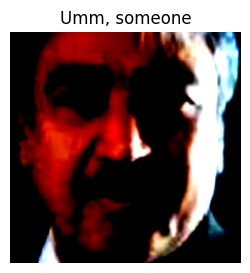

In [30]:
class GenderAgeDataset(Dataset):
    GENDER_DICT = {
        0: 'male',
        1: 'female'
    }

    def __init__(self, path: str, train: bool):
        self.x = glob(os.path.join(path, '*.jpg'))

        threshold = int(len(self.x) * 0.8)
        if train:
            self.x = self.x[:threshold]
        else:
            self.x = self.x[threshold:]

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        splitted_name = os.path.basename(self.x[idx]).split('_')
        age = splitted_name[0]
        gender = splitted_name[1]

        img = self.process_img(self.x[idx])

        return img, np.float32(age), np.float32(gender)

    def process_img(self, img_path):
        img = np.copy(ts.read(img_path))
        img = self.transform(img)

        return img


trn_dataset = GenderAgeDataset('./data/utkfaces_cropped', train=True)
trn_dataloader = DataLoader(trn_dataset, 64, True)

val_dataset = GenderAgeDataset('./data/utkfaces_cropped', train=False)
val_dataloader = DataLoader(val_dataset, 32, True)

im, age, gender, = trn_dataset[np.random.randint(0, len(trn_dataset))]
ts.show(im, title='Umm, someone', sz=3)

In [31]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

In [32]:
class AgeGenderClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.intermediate = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
        )

        self.age_classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.ReLU(),
        )
        self.gender_classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256, 1),  # 0 male, 1 female
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.intermediate(x)

        _age = self.age_classifier(x)
        _gender = self.gender_classifier(x)

        return _age, _gender

In [33]:
for p in model.parameters(): p.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(2)
model.classifier = AgeGenderClassifier()

In [34]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [35]:
age_criterion = nn.MSELoss()  # todo try doing probabilities of 116 output
gender_criterion = nn.BCELoss()
opt = optim.SGD(model.parameters(), 1e-5)
schedular = optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    factor=0.7,
    patience=10,
    threshold=1e-2,
    threshold_mode='rel',
)

In [36]:
trn_losses, val_losses = [], []

In [41]:
epochs = 2
from torch_snippets import *
reporter = Report()

for epoch in range(epochs):
    for img, age, gender in trn_dataloader:
        model.train()
        _age, _gender = model(img)

        loss = age_criterion(_age, age.unsqueeze(-1)) + gender_criterion(_gender, gender.unsqueeze(-1))

        opt.zero_grad()
        loss.backward()
        opt.step()

        trn_losses.append(loss)

        # print(f'Done, trn loss: {loss}')
        # with torch.no_grad():
        #     model.eval()
        #     for val_img, val_age, val_gender in val_dataloader:
        #         _val_age, _val_gender = model(val_img)
        #         val_loss = age_criterion(_val_age, val_age.unsqueeze(-1)) + gender_criterion(_val_gender, val_gender.unsqueeze(-1))
        #         val_losses.append(val_loss)            
        #         break

        # print(f'Done with val, val loss: {val_losses[-1]}')
        print(f'trn loss: {trn_losses[-1]}')

    print(f'Epoch {epoch}, trn loss {trn_losses[-1]}')

NameError: name 'Report' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5134494].


'predicted: age 37.42, gender 0.54, actual: age 62.00, gender 1.00'

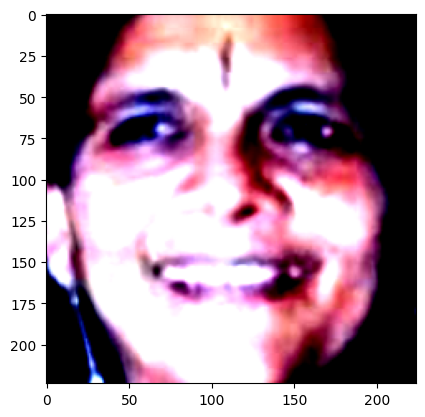

In [210]:
model.eval()
img, age, gender = val_dataset[np.random.randint(0, len(val_dataset))]
_age, _gender = model(img[None])

plt.imshow(img.permute(1, 2, 0))

f'predicted: age {_age.item():.2f}, gender {_gender.item():.2f}, actual: age {age.item():.2f}, gender {gender.item():.2f}'